<a href="https://colab.research.google.com/github/ELBrown11/Analyzing-Customer-Churn-using-Machine-Learning/blob/main/CustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler


# **Import Data**
- create `original_data` to store raw data as variable
- create `data` as copy of to be altered during data cleaning

In [2]:
original_data = pd.read_csv('/content/drive/MyDrive/Data Scientist Blog Post/Databel - Data.csv')
data = original_data.copy()

# **Preview Data**

In [3]:
data.head()

,Customer ID,Churn Label,Account Length (in months),Local Calls,Local Mins,Intl Calls,Intl Mins,Intl Active,Intl Plan,Extra International Charges,...,Senior,Group,Number of Customers in Group,Device Protection & Online Backup,Contract Type,Payment Method,Monthly Charge,Total Charges,Churn Category,Churn Reason
0,4444-BZPU,No,1,3,8.0,0.0,0.0,No,no,0.0,...,No,No,0,No,Month-to-Month,Direct Debit,10,10,NaN,NaN
1,5676-PTZX,No,33,179,431.3,0.0,0.0,No,no,0.0,...,No,No,0,Yes,One Year,Paper Check,21,703,NaN,NaN
2,8532-ZEKQ,No,44,82,217.6,0.0,0.0,No,yes,0.0,...,No,No,0,Yes,One Year,Direct Debit,23,1014,NaN,NaN
3,1314-SMPJ,No,10,47,111.6,60.0,71.0,Yes,yes,0.0,...,No,No,0,No,Month-to-Month,Paper Check,17,177,NaN,NaN
4,2956-TXCJ,No,62,184,621.2,310.0,694.4,Yes,yes,0.0,...,No,No,0,No,One Year,Direct Debit,28,1720,NaN,NaN


# **Data Cleaning and Exploration**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6687 entries, 0 to 6686
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        6687 non-null   object 
 1   Churn Label                        6687 non-null   object 
 2   Account Length (in months)         6687 non-null   int64  
 3   Local Calls                        6687 non-null   int64  
 4   Local Mins                         6687 non-null   float64
 5   Intl Calls                         6687 non-null   float64
 6   Intl Mins                          6687 non-null   float64
 7   Intl Active                        6687 non-null   object 
 8   Intl Plan                          6687 non-null   object 
 9   Extra International Charges        6687 non-null   float64
 10  Customer Service Calls             6687 non-null   int64  
 11  Avg Monthly GB Download            6687 non-null   int64

- `Churn Category` and `Churn Reason` are the only columns with missing data.
- this makes sense because some customers are retained and therefore no data would populate for this column

In [5]:
# Convert column names to lowercased and underscored
data.columns = data.columns.str.lower().str.replace(' ', '_')

# Display modified column names
print("\nModified column names:")
print(data.columns)


Modified column names:
Index(['customer_id', 'churn_label', 'account_length_(in_months)',
       'local_calls', 'local_mins', 'intl_calls', 'intl_mins', 'intl_active',
       'intl_plan', 'extra_international_charges', 'customer_service_calls',
       'avg_monthly_gb_download', 'unlimited_data_plan', 'extra_data_charges',
       'state', 'phone_number', 'gender', 'age', 'under_30', 'senior', 'group',
       'number_of_customers_in_group', 'device_protection_&_online_backup',
       'contract_type', 'payment_method', 'monthly_charge', 'total_charges',
       'churn_category', 'churn_reason'],
      dtype='object')


- converting the column names to the snake case for ease of use
- snake case is the convention where everything is lowercased and spaces are replaced with underscored

In [6]:
data['churn_label'].value_counts(normalize=True)

,proportion
churn_label,
No,0.731419
Yes,0.268581


- most customers do not churn but almost 27% of customers churn is a significant churn rate

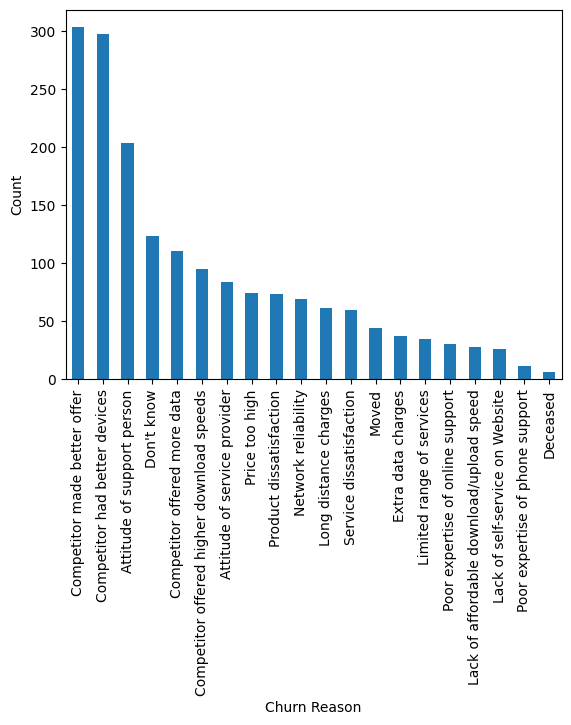

In [7]:
data['churn_reason'].value_counts().plot(kind='bar');
plt.xlabel('Churn Reason')
plt.ylabel('Count')
plt.show()

- 3 of top 5  reasons that customers churn are related to the "competitor"  

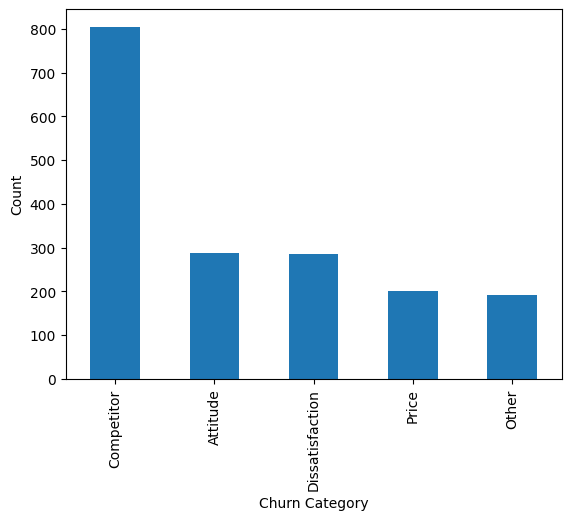

In [8]:
data['churn_category'].value_counts().plot(kind='bar');
plt.xlabel('Churn Category')
plt.ylabel('Count')
plt.show()

- this finding is inline with what we just saw via churn reason, competitors seem to be doing something to intice customers to leave


# **Answering Business Questions**

These are the question I originally posed when first understanding what kind of data was available and how it could help with Databel's business goals.

## **What features make a customer more likely to churn?**

churn_label                     1.000000
customer_service_calls          0.635533
monthly_charge                  0.214691
age                             0.107517
avg_monthly_gb_download         0.039947
extra_data_charges              0.005222
extra_international_charges    -0.019699
intl_mins                      -0.085395
intl_calls                     -0.092295
total_charges                  -0.173316
number_of_customers_in_group   -0.226341
local_calls                    -0.282273
local_mins                     -0.294757
account_length_(in_months)     -0.351517
Name: churn_label, dtype: float64


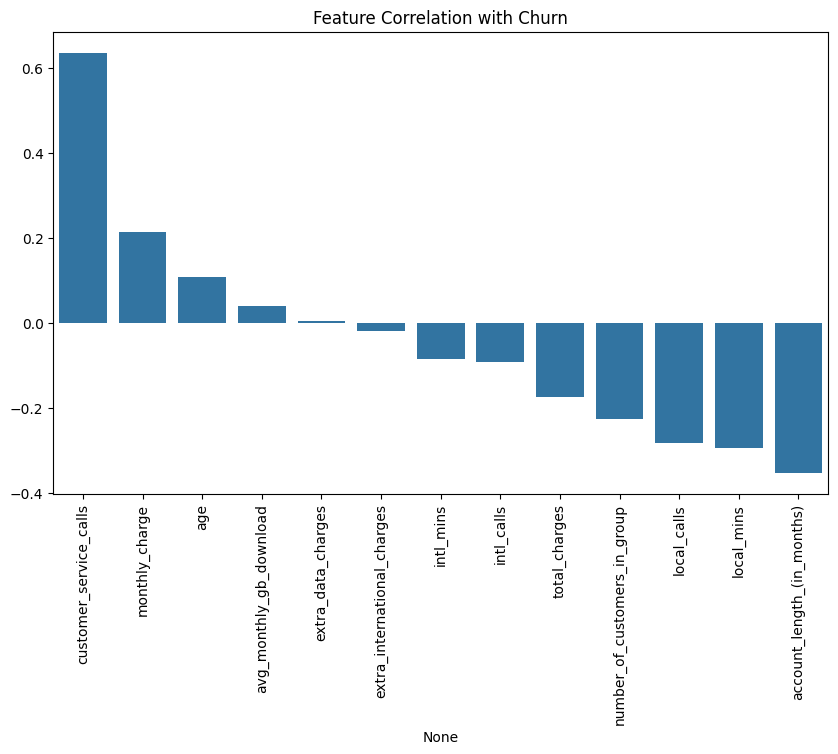

In [9]:
#What features make a customer more likely to churn?
# Convert churn label to binary (Yes = 1, No = 0)
data['churn_label'] = data['churn_label'].map({'Yes': 1, 'No': 0})

# Compute correlation with churn
correlation = data.corr(numeric_only=True)['churn_label'].sort_values(ascending=False)
print(correlation)

# Visualizing feature importance with barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.index[1:], y=correlation.values[1:])
plt.xticks(rotation=90)
plt.title("Feature Correlation with Churn")
plt.show()

- what this tells us...
  - `customer_service_calls`, `monthly charge`, `age` make churn more likely
    - data in `customer_service_calls` column is a strong predictor of churn. customers with more customer service interactions are more likely to churn
    - higher monthly charge increases change of churn
    - older customers more likely to churn but no as strong a predictor as customer service
  - `total_charges`, `number_of_customers_in_group`, `local_cals` are all features that reduce churn.
    - customers who have paid more overal are less likey to churn possibly becasue they are commited to their phone plan/company
    - those with larger numbers of customer in group (bundles) less likely to churn for likely similar reasons of commitment
- tenured customers with family plans are the most retained, a company should foucs on incentivizing long-term family deals for retention
- could explore this further via logistic regression or decision tree which could more thoroughly show feature importance

## **What percentage of customers are churning?**

In [10]:
data['churn_label_cat']= data['churn_label'].map({1: 'Yes', 0: 'No'})
churn_rate = data['churn_label_cat'].value_counts(normalize=True)*100
print(churn_rate)

churn_label_cat
No     73.141917
Yes    26.858083
Name: proportion, dtype: float64


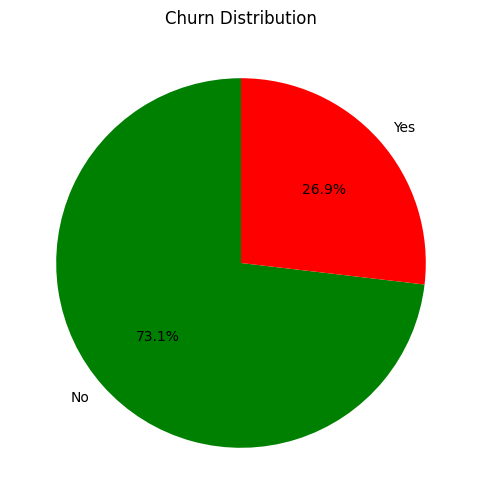

In [11]:
plt.figure(figsize=(6, 6))
plt.pie(churn_rate, labels=churn_rate.index, autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
plt.title("Churn Distribution")
plt.show()

- although this is similar to what was done during data exploration the visual is better way of sharing this information with a stakeholder to show how signifant a chunk of customers are being lost

## **Is there a relationship between certain demographics (e.g., age groups, gender, location) and churn rate?**

In [12]:
data.columns

Index(['customer_id', 'churn_label', 'account_length_(in_months)',
       'local_calls', 'local_mins', 'intl_calls', 'intl_mins', 'intl_active',
       'intl_plan', 'extra_international_charges', 'customer_service_calls',
       'avg_monthly_gb_download', 'unlimited_data_plan', 'extra_data_charges',
       'state', 'phone_number', 'gender', 'age', 'under_30', 'senior', 'group',
       'number_of_customers_in_group', 'device_protection_&_online_backup',
       'contract_type', 'payment_method', 'monthly_charge', 'total_charges',
       'churn_category', 'churn_reason', 'churn_label_cat'],
      dtype='object')

gender
Female               0.271736
Male                 0.265463
Prefer not to say    0.285714
Name: churn_label, dtype: float64


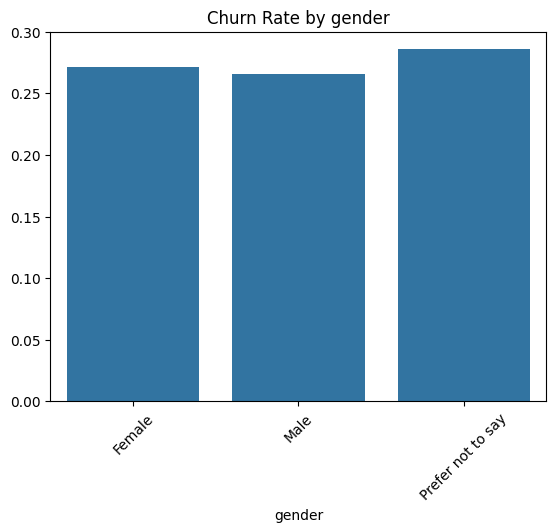

state
AK    0.288462
AL    0.285714
AR    0.245455
AZ    0.234375
CA    0.632353
CO    0.219697
CT    0.256757
DC    0.194444
DE    0.303279
FL    0.212598
GA    0.231481
HI    0.264151
IA    0.266667
ID    0.278912
IL    0.284483
IN    0.293706
KS    0.255319
KY    0.305085
LA    0.242718
MA    0.251908
MD    0.328571
ME    0.233871
MI    0.273973
MN    0.226190
MO    0.283465
MS    0.284615
MT    0.313869
NC    0.205882
ND    0.250000
NE    0.327869
NH    0.321429
NJ    0.270073
NM    0.241935
NV    0.272727
NY    0.233533
OH    0.348101
OK    0.195122
OR    0.307692
PA    0.333333
RI    0.251908
SC    0.300000
SD    0.225000
TN    0.226415
TX    0.289655
UT    0.250000
VA    0.270968
VT    0.265306
WA    0.219697
WI    0.250000
WV    0.267606
WY    0.246753
Name: churn_label, dtype: float64


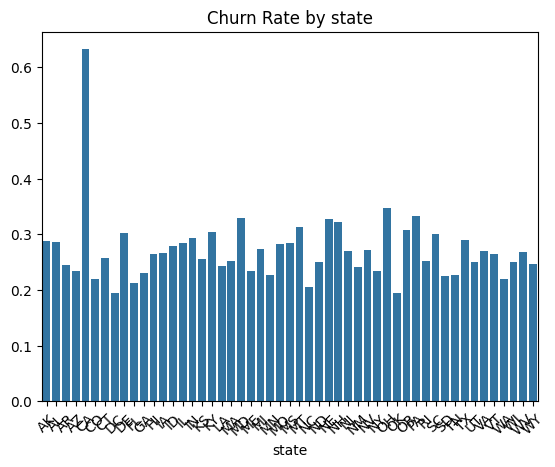

under_30
No     0.277778
Yes    0.229992
Name: churn_label, dtype: float64


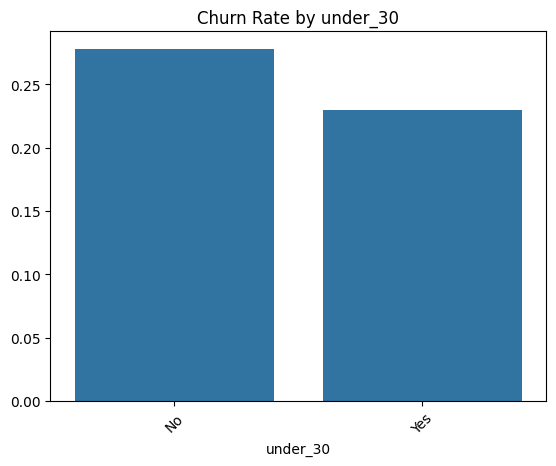

senior
No     0.241760
Yes    0.384554
Name: churn_label, dtype: float64


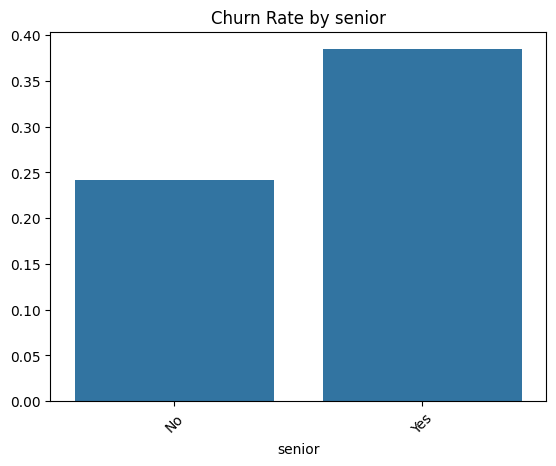

In [13]:
demographic_factors = ['gender', 'state', 'under_30', 'senior']
for factor in demographic_factors:
    churn_by_factor = data.groupby(factor)['churn_label'].mean()
    print(churn_by_factor)

    sns.barplot(x=churn_by_factor.index, y=churn_by_factor.values)
    plt.xticks(rotation=45)
    plt.title(f"Churn Rate by {factor}")
    plt.show()


- outside of the seniors, the other features have similar levels of churn through each group.


## **Which churn categories are most common?**

churn_category
Competitor         805
Attitude           287
Dissatisfaction    286
Price              200
Other              191
Name: count, dtype: int64


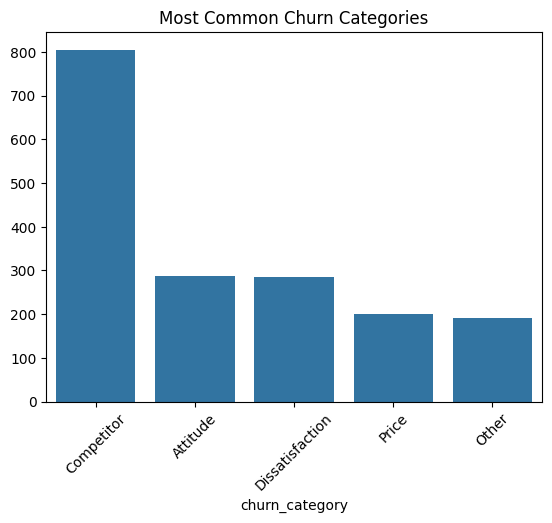

In [14]:
churn_categories = data['churn_category'].value_counts()
print(churn_categories)

sns.barplot(x=churn_categories.index, y=churn_categories.values)
plt.xticks(rotation=45)
plt.title("Most Common Churn Categories")
plt.show()

- also similar to what was shown in data exploration but made it more visually pleasing
- after finding out more about the correlations with churn label it may be interesting to do a similar analysis with churn categories later


# **Modeling Data**
- will being using supervised classification models and assessing the performance
  - Logistic Regression
  - Random Forest
  - XGBoost
- we want to predict customer churn in hopes of mitigating it in the future
- we completed some data cleaning in previous steps but now that we're thinking more about the needs of the model we will do some more additional preprocessing


## **Preprocessing**

### **Handling Missing Data in `churn_category` and `churn_reason` Columns**
- since we understand that this data is missing because it does not apply to non-churning customers we will replace the blanks with "non-churner" to make it clear why what these blanks mean.
- this info can also be helpful to the model
- will be using

In [15]:
data['churn_category'] = data['churn_category'].fillna('non-churner')
data['churn_reason'] = data['churn_reason'].fillna('non-churner')

In [16]:
data[['intl_active', 'intl_plan', 'unlimited_data_plan', 'senior', 'under_30']]

,intl_active,intl_plan,unlimited_data_plan,senior,under_30
0,No,no,Yes,No,No
1,No,no,Yes,No,No
2,No,yes,Yes,No,No
3,Yes,yes,Yes,No,No
4,Yes,yes,Yes,No,No
...,...,...,...,...,...
6682,No,no,Yes,No,No
6683,No,no,Yes,No,Yes
6684,No,no,Yes,No,No
6685,No,no,Yes,No,No


- here i'm checking the columns which i believed to be binary to see that if they all have the same vase structure before mapping them to 0 and 1
- we can see that some columns are all lowercase and some have title case so they need to be changed to lower case and then mapped

### **Changing Binary Categorial Data to Numerical Values (0/1)**

In [17]:
# Ensure all values in binary columns are lowercase before mapping
binary_cols = ['intl_active', 'intl_plan', 'unlimited_data_plan', 'senior', 'under_30']

data[binary_cols] = data[binary_cols].apply(lambda x: x.str.lower().map({'yes': 1, 'no': 0}))

### **One-Hot Encoding Nominal Variables**
- to ensure that categorical data is used effectively in the models

In [18]:
# One-hot encode nominal categorical variables
cat_cols = ['contract_type', 'payment_method', 'state', 'gender', 'group', 'device_protection_&_online_backup','churn_category','churn_reason']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

### **Drop Unnecessary Columns**

In [19]:
# Drop unique identifiers and redundant columns
data.drop(columns=['customer_id', 'phone_number', 'churn_label_cat'], inplace=True)

### **Split Data into Training and Testing Sets**

In [20]:
# Define features (X) and target (y)
X = data.drop(columns=['churn_label'])
y = data['churn_label']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### **Feature Scaling**
- to normalize the numerical features of the data

In [21]:
# Select numerical features for scaling
num_cols = ['account_length_(in_months)', 'local_calls', 'local_mins', 'intl_calls',
            'intl_mins', 'extra_international_charges', 'customer_service_calls',
            'avg_monthly_gb_download', 'extra_data_charges', 'monthly_charge', 'total_charges']

scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])


## **Logistic Regression**

In [22]:
#importing additional libraries
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


In [23]:
#training log regression model with balancing
log_reg = LogisticRegression(class_weight='balanced', random_state=42) #class_weight='balanced' to adjust for the imbalance of the target variable
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## **Random Forest**

In [28]:
#training random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

## **XGBoost**

In [30]:
#traing xgb model with balancing
xgb_model = XGBClassifier(scale_pos_weight=(73.1 / 26.9), use_label_encoder=False, eval_metric='logloss') #to handle imbalanced target variable
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:14:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## **Evaluating Model Performance**


Logistic Regression Performance:
Accuracy: 0.9005979073243647
ROC-AUC Score: 0.8950281823587823
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       979
           1       0.78      0.88      0.83       359

    accuracy                           0.90      1338
   macro avg       0.87      0.90      0.88      1338
weighted avg       0.91      0.90      0.90      1338



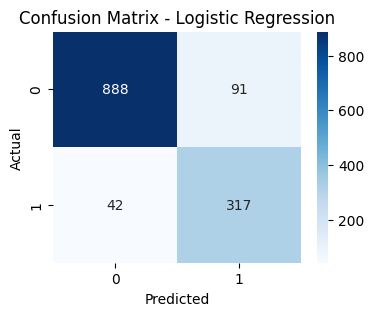


Random Forest Performance:
Accuracy: 0.9955156950672646
ROC-AUC Score: 0.9916434540389972
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       979
           1       1.00      0.98      0.99       359

    accuracy                           1.00      1338
   macro avg       1.00      0.99      0.99      1338
weighted avg       1.00      1.00      1.00      1338



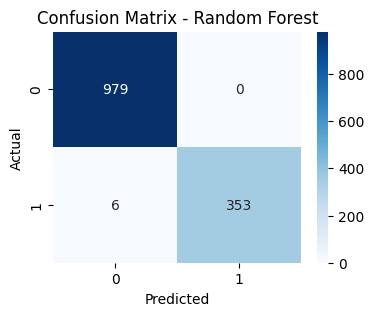


XGBoost Performance:
Accuracy: 0.9955156950672646
ROC-AUC Score: 0.9942895513300196
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       979
           1       0.99      0.99      0.99       359

    accuracy                           1.00      1338
   macro avg       0.99      0.99      0.99      1338
weighted avg       1.00      1.00      1.00      1338



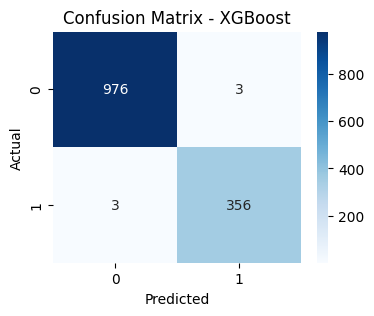

In [31]:
models = {'Logistic Regression': y_pred_log, 'Random Forest': y_pred_rf, 'XGBoost': y_pred_xgb}

for model_name, y_pred in models.items():
    print(f"\n{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()